# Лабораторная "представление сигнала в различных пространствах"

Лабораторная состоит из гайда по использованию преобразований Фурье и вейвлет на Python и 3 заданий:

* [Задание 1](#Задание-1.) - подобрать изображение, чтобы на спектре была окружность;

* [Задание 2](#Задание-2.) - "frame extrapolation";

* [Задание 3](#Задание-3.) - вейвлеты.

*В этом ноутбуке изначально опущены результаты исполнения кода. Рекомендуется запускать (Shift+Enter) ячейки по мере просмотра документа*

Сначала рекомендуется ознакомиться с гайдом, после чего выполнять задания.

---

#### Используемые модули

Обновим пакетный менеджер pip, чтобы корректно уставить необходимые модули:

In [1]:
# При необходимости добавляйте опцию --user
!pip install --upgrade pip

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\arina\anaconda3\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Установим необходимые модули:

In [2]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Подключим модули, которые пригодятся в мини-лабораторной.

In [3]:
import numpy as np

import pywt
import pywt.data

from imageio import imread, imsave

from skimage.color import rgb2gray, rgba2rgb

from matplotlib import pyplot as plt
%matplotlib inline

import os

from save_answer import add_to_answer

## Удаление "лишней" информации

Посмотрим на преобразование Фурье от картинки:

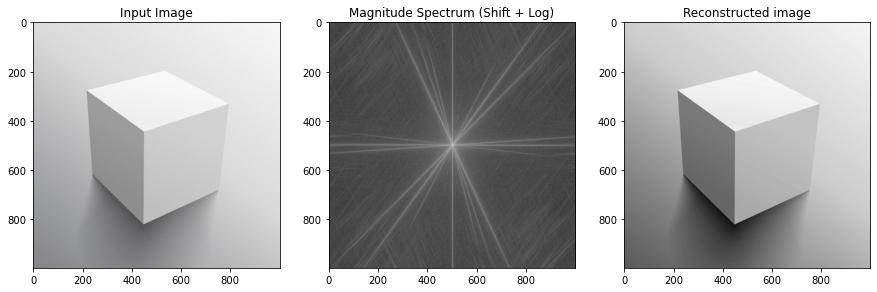

In [4]:
img = imread(os.path.join('images', 'cube.jpg'))

f = np.fft.fft2(rgb2gray(img))  # вычисляем 2D-FFT для изображения
fshift = np.fft.fftshift(f)     # переупорядочим значения, чтобы 0 частота была в центре
spectrum = 100 * np.log(np.abs(fshift))

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].set_title('Input Image')
ax[1].set_title('Magnitude Spectrum (Shift + Log)')
ax[2].set_title('Reconstructed image')

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(spectrum, cmap = 'gray')

transformed_fshift = fshift.copy()
transformed_fshift[0:400, 0:100] = 0  # удалим куски, не содержащие светлых прямых на спектре, это не повлияет на рёбра куба
transformed_fshift[600:900, 800:1000] = 0
inv = np.fft.ifft2(np.fft.ifftshift(transformed_fshift)).real  # восстановим изображение обратным преобразованием
ax[2].imshow(inv, cmap='gray')

plt.show()

---

### Задание 1.

Подберите такое изображение, чтобы на спектре была окружность.

Изображение можно искусственно сгенерировать (к примеру, составить подходящий `numpy`-массив). В таком случае сначала сохраните исходное изображение в репозиторий, а потом прочитайте его из этого файла в переменную `task_1_image` - это нужно для удобства проверки, чтобы `answers.json` указывал путь до исходного изображения.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


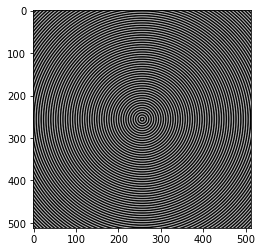

In [7]:
x, y = np.meshgrid(range(512), range(512))
r = np.sqrt((x - 256) ** 2 + (y - 256) ** 2)
task_1_image = np.stack([np.sin(400 * r / r.max())] * 3, axis=-1)

plt.imshow(task_1_image)

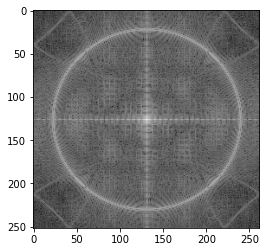

In [10]:
task_1_image = 'task.png'
img_2 = imread(os.path.join('images', task_1_image))


plt.imshow(100 * np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(rgba2rgb(img_2)))))), cmap='gray')
task_1_result = os.path.join('images', 'task_1.png')
plt.savefig(task_1_result)

Не забудьте сохранить результат, выполнив ячейку ниже:

In [11]:
add_to_answer(
    "task_1",
    {
        "source_image": task_1_image,
        "result_image": task_1_result,
    },
)

---

## Усиление движений

### Задание 2.

Ниже приведён код, создающий два изображения (белые квадраты на чёрном фоне). Представьте, что это фрагмент видеозаписи, в которой квадрат движется из левого верхнего угла в правый нижний по прямой. Нам представлены только два соседних кадра (`frame_a` и `frame_b`), по ним требуется предсказать третий кадр `frame_c` (следующий за `frame_b` через промежуток времени, равный промежутку между `frame_a` и `frame_b`) *- примитивный вариант задачи "frame extrapolation"*.

Будем решать задачу следующим образом: применим к изображениям преобразование Фурье, найдём амплитуду и фазу сигнала каждого кадра. По ним определим амплитуду и фазу сигнала искомого кадра `frame_c` (они должны как-то зависеть от амплитуд и фаз `frame_a` и `frame_b`, **как – решать вам**) и далее реконструируем искомое изображение.

Вам в задании требуется изменить **две строки**, отмеченных знаком `(!)` в комментариях, так, чтобы реконструируемый кадр `frame_c` соответствовал описанию (белый квадрат должен оказаться в правом нижнем углу, с координатами центра примерно (75, 75)).

*Данное решение приведено только как интересный пример. На самом деле задачу прогнозирования кадров, как и интерполирования (создания slow motion), обычно решают с помощью нахождения <u>оптического потока</u> в явном виде*.

In [12]:
# Код генерации первых двух изображений
canvas = np.zeros((100, 100))
frame_a = canvas.copy()
frame_b = canvas.copy()

frame_a[20:30, 20:30] = 1.0  # "Рисуем" квадрат на первом изображении
frame_b[44:55, 45:55] = 1.0  # "Рисуем" квадрат на втором изображении

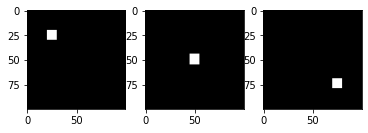

In [14]:
# перевод изображений в частотное пространство
f_a = np.fft.fftshift(np.fft.fft2(frame_a))
f_b = np.fft.fftshift(np.fft.fft2(frame_b))

# получение амплитуд и фаз сигналов
magnitude_a = np.abs(f_a)
magnitude_b = np.abs(f_b)
phase_a = np.angle(f_a)
phase_b = np.angle(f_b)

# само задание - поменять следующие две строки:
magnitude_c = magnitude_a # (!) возможно, надо поменять эту строку
phase_c = phase_a + 2 * (phase_b - phase_a)  # (!) и/или эту

# получение нового сигнала в частотном пространстве из модуля и аргумента
f_c = magnitude_c * np.exp(1.0j * phase_c)
# перевод в исходное пространство
frame_c = np.fft.ifft2(np.fft.ifftshift(f_c)).real

fig, ax = plt.subplots(1, 3)
ax[0].imshow(frame_a, cmap='gray')
ax[1].imshow(frame_b, cmap='gray')
ax[2].imshow(frame_c, cmap='gray')

task_2_result = os.path.join('images', 'task_2.png')
plt.savefig(task_2_result)

Не забудьте сохранить результат, выполнив ячейку ниже:

In [15]:
add_to_answer(
    "task_2",
    {
        "result_image": task_2_result,
    },
)

---

## Вейвлеты

Вейвлет - любой сигнал, задающий локальное преобразованиие с нулевым средним. Амплитуда сигнала вейвлета сначала 0, затем произвольная с нулевым средним (интеграл амплитуды по числовой оси равен 0), затем снова 0. Здесь слово "сигнал" можно заменить словом "функция".
Примерами вейвлетов являются фильтры Соболя, Превитта и другие (рассматривавшиеся при поиске границ изображения).

Вейвлет-преобразование представляет собой свертку с фильтром, задаваемым вейвлетом.

Вейвлет-разложениие - разложение по набору масштабированных и смещенных вейвлетов (версий одной базовой функции-фильтра вейвлета). Оно позволяет разложить одномерный кусочно-непрерывный сигнал с конечным числом точек разрыва на конечное число составляющих. Также вейвлет-разложение может быть удобно для сжатия.

Ниже приведен код, загружающий избражение и применяющий к нему фильтры [вейвлета Мейера](http://wavelets.pybytes.com/wavelet/dmey/).

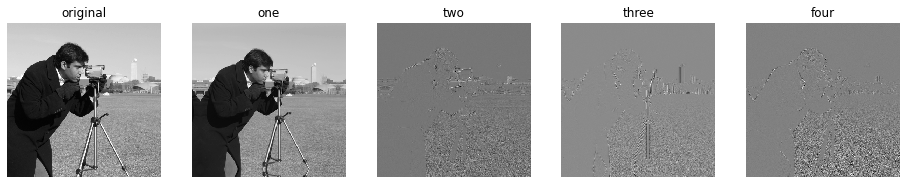

In [16]:
# Загрузка изображения
original = pywt.data.camera()

def apply_filters(image):
    one, (two, three, four) = pywt.dwt2(image, 'dmey')  # Применение фильтров
    fig = plt.figure(figsize=(16, 3))
    titles = ('original', 'one', 'two', 'three', 'four')
    for i, a in enumerate((image, one, two, three, four)):
        ax = fig.add_subplot(1, 5, i + 1)
        ax.imshow(a, interpolation="nearest", cmap='gray')
        ax.set_title(titles[i], fontsize=12)
        ax.set_axis_off()

apply_filters(original)
        
fig.tight_layout()
plt.show()

---

### Задание 3.

Подберите либо сконструируйте входное изображение, при котором результаты применения:
1. `one` и `two` совпадают$^*$
2. `three` и `four` совпадают$^*$
3. `one` и `three` различаются$^*$

$^*$ - сравниваются "нормализованные" результаты: в полученных `numpy`-массивах сначала "пиксели" картинок делятся на максимальные значения внутри каждой картинки, после чего нормализованные результаты сравниваются. Вовсе не обязательно, чтобы, например, `one` и `two` совпадали попиксельно до применения нормализации, но обязательно, чтобы совпадали с учётом нормализации.

Все условия выполнены!


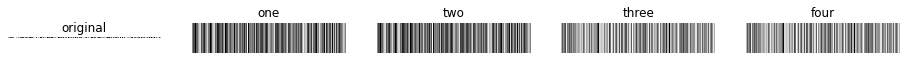

In [17]:
img_3 = np.random.permutation(np.arange(256)).reshape(1, -1)  # Сгенерируйте подходящее изображение
# img_3 = imread(os.path.join('images', <your image>))  # Или подберите картинку и загрузите её
img_3 = rgb2gray(img_3) if len(img_3.shape) == 3 and img_3.shape[-1] == 3 else img_3 # Перевод в чёрно-белый формат (если нужно)

def check(image):
    # Эта проверка нужна, чтобы убедиться, что условия выполнены, после визуальной проверки
    one, (two, three, four) = pywt.dwt2(image, 'dmey')  # Применение фильтров
    normalized = tuple(map(lambda arr: arr / arr.max(), (one, two, three, four)))
    
    def arrs_equal(arr1, arr2):
        return (arr1 - arr2).sum() < 1e-8
    
    cond_1 = arrs_equal(normalized[0], normalized[1])
    cond_2 = arrs_equal(normalized[2], normalized[3])
    cond_3 = not arrs_equal(normalized[0], normalized[2])
    
    for i, cond in enumerate((cond_1, cond_2, cond_3)):
        if not cond:
            print(f'Условие {i + 1} не выполнено!')
    print('Все условия выполнены!' if cond_1 and cond_2 and cond_3 else 'Подберите/сгенерируйте другое изображение')
    
check(img_3)
apply_filters(img_3)
task_3_result = os.path.join('images', 'task_3.png')
fig.tight_layout()
plt.savefig(task_3_result)
plt.show()

Не забудьте сохранить результат, выполнив ячейку ниже:

In [18]:
add_to_answer(
    "task_3",
    {
        "result_image": task_3_result,
    },
)